In [4]:
import numpy as np
from numpy import ma
import pykalman as pk
import os
import time
import pickle
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
from data import load_openl3_time_series as load_data

In [2]:
#choosing a sensor with a reasonable, readable amount of data
DATA_LOC = '/beegfs/work/sonyc/features/openl3/2017'
BEST_SENSOR_LOC = os.path.join(DATA_LOC, 'sonycnode-b827ebefb215.sonyc_features_openl3.h5')

In [4]:
#loading data for processing
data, mask = load_data(BEST_SENSOR_LOC)

/home/ci411/sonyc-kalman/sonyc_kalman/data.py:17: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(hdf5_path) as f:


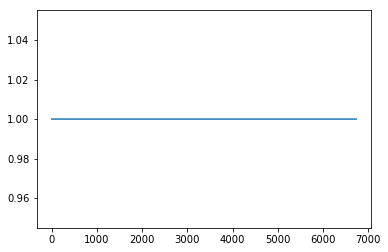

In [5]:
#checking mask
plt.plot(np.arange(len(mask)), mask)
plt.show()

In [34]:
#swapping mask conventions to match numpy.mas conventions
mask_flip = (mask==0).astype('int')

In [41]:
#attempting to holdout a portion of data on a 100 sample subset of the data
mini_data = data[:100]
mini_holdout = mini_data[45:56]
mini_data[45:56] = ma.masked

In [42]:
#constructing and training data on the subset
#(note that pykalman requires assigning the output of .em())
kf = pk.KalmanFilter(n_dim_state=2, n_dim_obs=data.shape[1], em_vars='all')
kf_trained = kf.em(mini_data, n_iter=5)

In [44]:
#examining smoothed/filtered latent state results
mini_smooth = kf_trained.smooth(mini_data)
mini_filter = kf_trained.filter(mini_data)

In [15]:
#time-testing em with data scale
n_data = [10, 100, 500, 1000, 3000, 5000]
times = []
kf_list = []
for n in n_data:
    print("Attempting {} training datapoints".format(n))
    tstart = time.time()
    kf = pk.KalmanFilter(n_dim_state=2, n_dim_obs=data.shape[1])
    kf.em(data[:n], n_iter=5)
    tend = time.time()
    times.append(tend-tstart)
    kf_list.append(kf)

Attempting 10 training datapoints
Attempting 100 training datapoints
Attempting 500 training datapoints


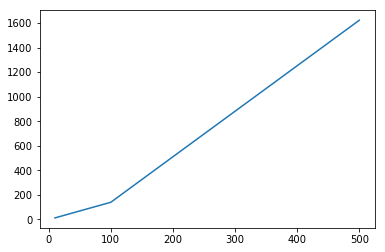

In [59]:
#plotting time tests
#results is n_data is linear with time
plt.plot(n_data, times)
plt.show()

In [70]:
loc = './mask_test.npz'
np.savez(loc, mask=mask)

In [71]:
mask_load = np.load(loc)

In [2]:
#testing the training function
!python ../train_pykalman.py --output_path . --data_range 100 --model_name "train_test"

Loading data from sonycnode-b827ebefb215.sonyc_features_openl3.h5
/home/ci411/sonyc-kalman/sonyc_kalman/data.py:19: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(hdf5_path) as f:
Training Kalman Filter: Sensor: sonycnode-b827ebefb215.sonyc_features_openl3.h5,	 N_Iterations: 5,	 Latent Space Dim2
Training complete, saving result to .


In [9]:
with open(os.path.join('.','train_test.pkl'), 'rb') as fd:
    pykal_load = pickle.load(fd)

In [10]:
pykal_load